#MNIST Dataset

In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

#Import libraries
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms

import torchvision

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.6.20
    Uninstalling certifi-2020.6.20:
      Successfully uninstalled certifi-2020.6.20


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Set seed for fastai
fastai.torch_core.set_seed(42)

# Set seed for torch
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

# Set seed for numpy
np.random.seed(42)

cuda


### Datos y modelos

In [3]:
#Load the MNIST dataset
dataset='MNIST'
plot_dataset='MNIST'


#Import the MNIST Dataset

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Resize([32,32])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)



# Reduce training and test datasets
reduced_train_dataset = utilsTFG.reduce_dataset(train_dataset, 10000)
reduced_test_dataset = utilsTFG.reduce_dataset(test_dataset, 5000)



In [4]:

print("Training set class distribution:")
utilsTFG.verify_class_balance(reduced_train_dataset)

print("\nTest set class distribution:")
utilsTFG.verify_class_balance(reduced_test_dataset)

Training set class distribution:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 1000 samples
Class 7: 1000 samples
Class 8: 1000 samples
Class 9: 1000 samples

Test set class distribution:
Class 0: 500 samples
Class 1: 500 samples
Class 2: 500 samples
Class 3: 500 samples
Class 4: 500 samples
Class 5: 500 samples
Class 6: 500 samples
Class 7: 500 samples
Class 8: 500 samples
Class 9: 500 samples


In [5]:
from torch.utils.data import DataLoader, random_split

valid_ratio=0.5
# The size of the validation set is the same as the size of the test set
validation_size = int(len(reduced_test_dataset)*valid_ratio)




train_subset = reduced_train_dataset

# Split the test dataset into validation and test subsets
validation_subset, test_subset = random_split(reduced_test_dataset, [validation_size,len(reduced_test_dataset)-validation_size])

# Define batch size
batch_size = 512

# Create DataLoader objects
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Check the size of each DataLoader
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(validation_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


Training set size: 10000
Validation set size: 2500
Test set size: 2500


In [6]:
dls = DataLoaders.from_dsets(train_subset, validation_subset, bs=batch_size)
test_dl = dls.test_dl(reduced_test_dataset)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
dls = DataLoaders.from_dsets(train_subset, validation_subset, bs=batch_size)
test_dl = dls.test_dl(reduced_test_dataset)

dls.to(device)
test_dl.to(device)

models =['LeNet5', 'ResNet15', 'ResNet57']
mod = [utilsTFG.LeNet5(), utilsTFG.ResNet15(num_classes=10), utilsTFG.ResNet57(num_classes=10)]
optims = ['NAG', 'RMSProp', 'ADAM']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['Acc']

init_weights = {}
for model, m in zip(models, mod):
  learn = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[model] = utilsTFG.get_params_from_model(learn.model)
  print(learn.summary())

LeNet5 (Input shape: 512 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 6 x 28 x 28   
Conv2d                                    156        True      
BatchNorm2d                               12         True      
____________________________________________________________________________
                     512 x 16 x 5 x 5    
MaxPool2d                                                      
____________________________________________________________________________
                     512 x 16 x 10 x 10  
Conv2d                                    2416       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 120           
Linear                                    48120      True      
BatchNorm1d                               240        True      
_________________________________________________

ResNet15 (Input shape: 512 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     512 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
Conv2d                                    1024 

ResNet57 (Input shape: 512 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     512 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
Conv2d                                    1024 

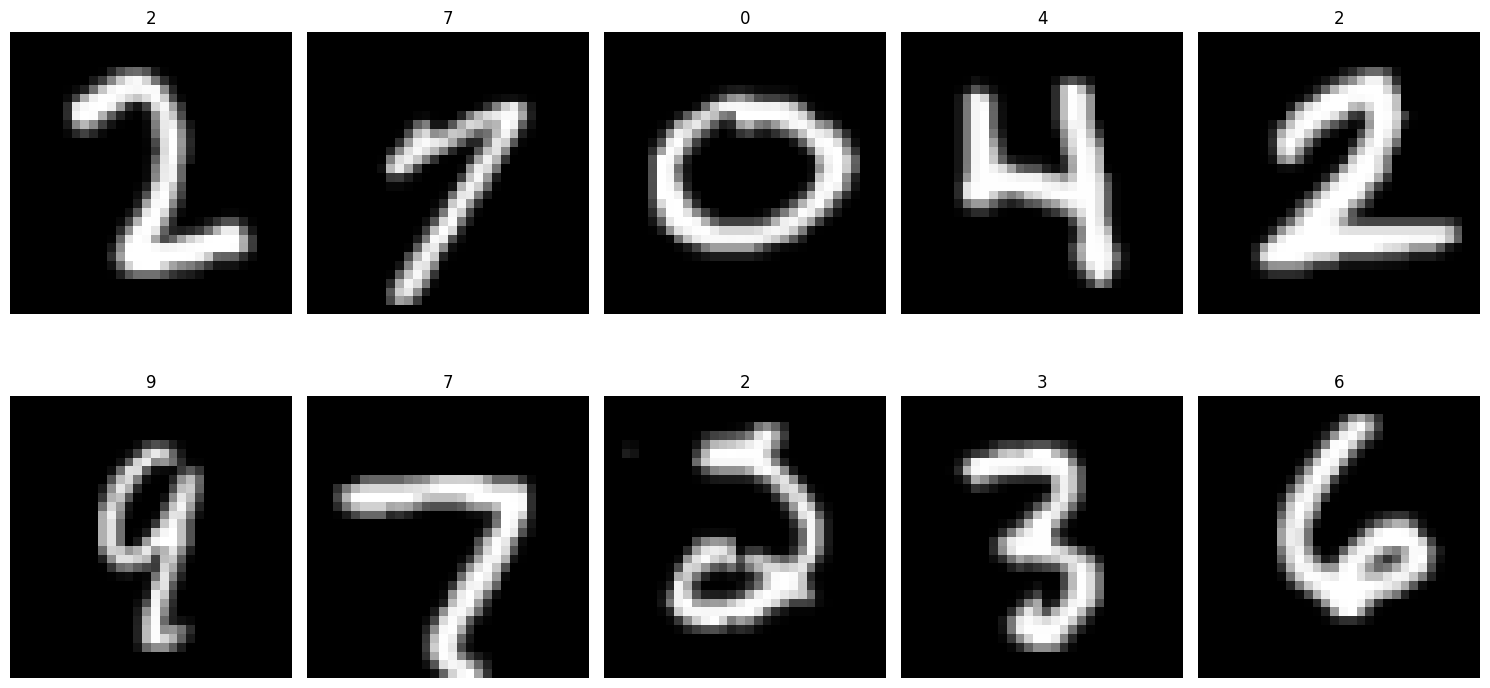

In [8]:
# Get a batch of images and labels
batch = dls.one_batch()

# Number of images to display
num_images = 10

# Create a figure with a grid of subplots (2 rows and 4 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Plot each image in the grid
for i in range(num_images):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    img = batch[0][i].cpu().squeeze().numpy()
    label = batch[1][i].item()
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

## Gradient Descent

In [9]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for model, m in zip(models,mod):
        learners[opt][model] = Learner(dls=dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][model].to(device)
        learners[opt][model].model.to(device)
        utilsTFG.set_params_to_model(init_weights[model], learners[opt][model].model)


In [10]:
#To check if the models have the same initial parameters
for model in models:
  if utilsTFG.compare_models(learners['NAG'][model], learners['RMSProp'][model]) and utilsTFG.compare_models(learners['NAG'][model], learners['ADAM'][model]) and utilsTFG.compare_models(learners['ADAM'][model], learners['RMSProp'][model]):
    print(f"Mismos parámetros con el modelo {model}.")
  else:
    print("Distintos parámetros.")

Mismos parámetros con el modelo LeNet5.
Mismos parámetros con el modelo ResNet15.
Mismos parámetros con el modelo ResNet57.


### Nesterov

epoch,train_loss,valid_loss,accuracy,time
0,2.666251,2.370100,0.136800,00:02
1,2.141840,1.553926,0.540800,00:02
2,1.614282,0.757526,0.831600,00:02
3,1.229192,0.535227,0.886000,00:02
4,0.961637,0.449608,0.905200,00:02
5,0.773585,0.383332,0.919200,00:02
6,0.636683,0.337445,0.927600,00:02
7,0.535583,0.304601,0.934400,00:02
8,0.457730,0.278798,0.938400,00:02
9,0.398336,0.259983,0.944400,00:02


Better model found at epoch 0 with valid_loss value: 2.3700997829437256.
Better model found at epoch 1 with valid_loss value: 1.553925633430481.
Better model found at epoch 2 with valid_loss value: 0.757525622844696.
Better model found at epoch 3 with valid_loss value: 0.5352268218994141.
Better model found at epoch 4 with valid_loss value: 0.4496084451675415.
Better model found at epoch 5 with valid_loss value: 0.38333213329315186.
Better model found at epoch 6 with valid_loss value: 0.3374450206756592.
Better model found at epoch 7 with valid_loss value: 0.3046007454395294.
Better model found at epoch 8 with valid_loss value: 0.27879759669303894.
Better model found at epoch 9 with valid_loss value: 0.2599826753139496.
Better model found at epoch 10 with valid_loss value: 0.23921950161457062.
Better model found at epoch 11 with valid_loss value: 0.22596710920333862.
Better model found at epoch 12 with valid_loss value: 0.21606452763080597.
Better model found at epoch 13 with valid_los

epoch,train_loss,valid_loss,accuracy,time
0,3.507473,2.772295,0.107200,00:03
1,2.689210,2.878850,0.155200,00:03
2,1.967112,1.570941,0.441600,00:03
3,1.448006,0.516020,0.840800,00:03
4,1.088936,0.303409,0.912400,00:03
5,0.843488,0.255918,0.922800,00:03
6,0.667104,0.224788,0.932400,00:03
7,0.545979,0.207980,0.939200,00:03
8,0.448835,0.192492,0.940000,00:03
9,0.376658,0.181607,0.946400,00:03


Better model found at epoch 0 with valid_loss value: 2.7722952365875244.
Better model found at epoch 2 with valid_loss value: 1.5709412097930908.
Better model found at epoch 3 with valid_loss value: 0.5160201787948608.
Better model found at epoch 4 with valid_loss value: 0.30340883135795593.
Better model found at epoch 5 with valid_loss value: 0.2559182941913605.
Better model found at epoch 6 with valid_loss value: 0.22478759288787842.
Better model found at epoch 7 with valid_loss value: 0.20797963440418243.
Better model found at epoch 8 with valid_loss value: 0.19249191880226135.
Better model found at epoch 9 with valid_loss value: 0.1816065013408661.
Better model found at epoch 10 with valid_loss value: 0.1720457822084427.
Better model found at epoch 11 with valid_loss value: 0.1664864718914032.
Better model found at epoch 12 with valid_loss value: 0.16293644905090332.
Better model found at epoch 13 with valid_loss value: 0.1554775983095169.
Better model found at epoch 14 with valid_

epoch,train_loss,valid_loss,accuracy,time
0,3.632597,2.937170,0.097200,00:04
1,3.379731,2.497403,0.192800,00:04
2,2.957474,2.623850,0.372000,00:03
3,2.416289,1.147496,0.657600,00:04
4,1.882682,0.595460,0.815200,00:03
5,1.447065,0.418811,0.871600,00:03
6,1.110232,0.331520,0.895600,00:03
7,0.855709,0.297760,0.905600,00:03
8,0.661932,0.255732,0.917600,00:03
9,0.515109,0.241065,0.926400,00:03


Better model found at epoch 0 with valid_loss value: 2.9371697902679443.
Better model found at epoch 1 with valid_loss value: 2.497403383255005.
Better model found at epoch 3 with valid_loss value: 1.1474964618682861.
Better model found at epoch 4 with valid_loss value: 0.5954599380493164.
Better model found at epoch 5 with valid_loss value: 0.41881075501441956.
Better model found at epoch 6 with valid_loss value: 0.3315200209617615.
Better model found at epoch 7 with valid_loss value: 0.2977597415447235.
Better model found at epoch 8 with valid_loss value: 0.2557324171066284.
Better model found at epoch 9 with valid_loss value: 0.24106469750404358.
Better model found at epoch 10 with valid_loss value: 0.22793862223625183.
Better model found at epoch 11 with valid_loss value: 0.21666865050792694.
Better model found at epoch 12 with valid_loss value: 0.21108105778694153.
Better model found at epoch 13 with valid_loss value: 0.20467078685760498.
Better model found at epoch 16 with valid_

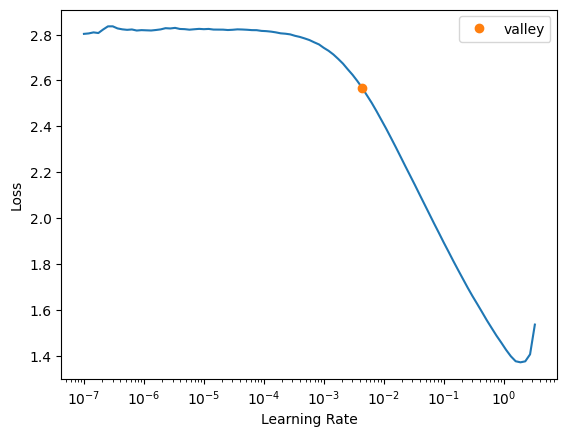

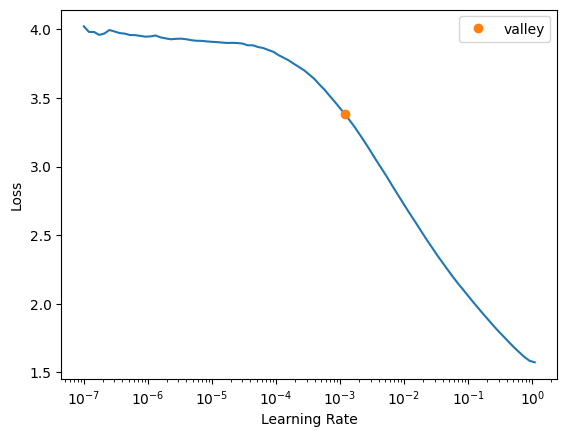

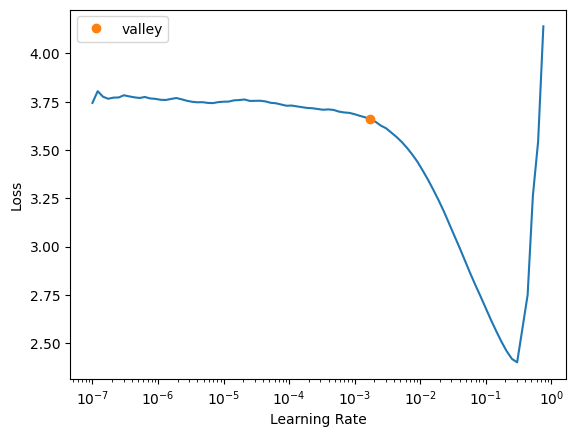

In [11]:
#Run the training and measure the time for each layer
for model, learner in learners['NAG'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][model] = end-start



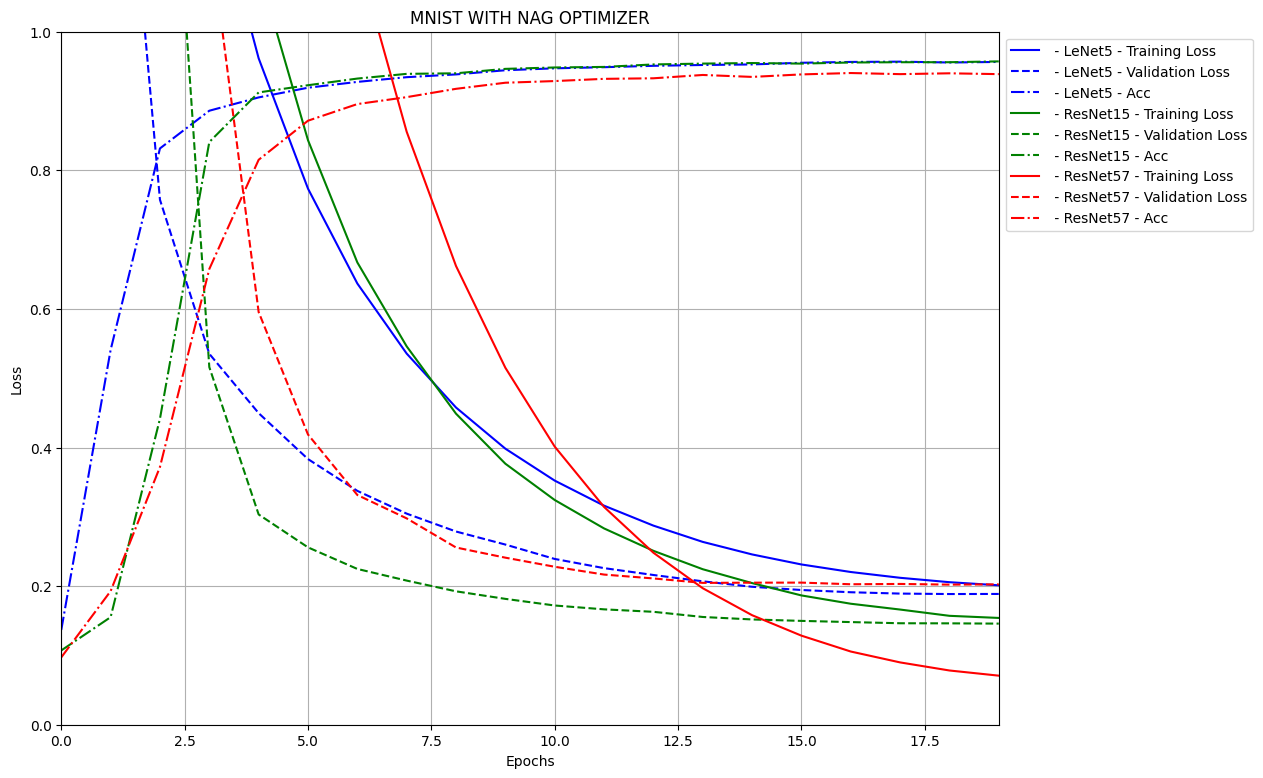

In [12]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title=f'{plot_dataset} WITH NAG OPTIMIZER', names=models, metric=metric)

### RMSProp

epoch,train_loss,valid_loss,accuracy,time
0,1.382980,1.553666,0.507200,00:02
1,0.769849,0.246346,0.924400,00:02
2,0.485573,0.125421,0.962800,00:02
3,0.326432,0.067766,0.980800,00:02
4,0.226719,0.062366,0.980000,00:02
5,0.161327,0.055675,0.982800,00:02
6,0.115984,0.049970,0.985200,00:02
7,0.083990,0.046857,0.986400,00:02
8,0.060899,0.046166,0.985200,00:02
9,0.044081,0.044184,0.986000,00:02


Better model found at epoch 0 with valid_loss value: 1.5536658763885498.
Better model found at epoch 1 with valid_loss value: 0.246346116065979.
Better model found at epoch 2 with valid_loss value: 0.12542062997817993.
Better model found at epoch 3 with valid_loss value: 0.06776569038629532.
Better model found at epoch 4 with valid_loss value: 0.062365904450416565.
Better model found at epoch 5 with valid_loss value: 0.05567457154393196.
Better model found at epoch 6 with valid_loss value: 0.04997041076421738.
Better model found at epoch 7 with valid_loss value: 0.04685746878385544.
Better model found at epoch 8 with valid_loss value: 0.04616563767194748.
Better model found at epoch 9 with valid_loss value: 0.04418430104851723.
Better model found at epoch 11 with valid_loss value: 0.04089432209730148.
Better model found at epoch 14 with valid_loss value: 0.03986649960279465.


epoch,train_loss,valid_loss,accuracy,time
0,2.436528,3.761694,0.102400,00:03
1,1.345145,6.645144,0.102400,00:03
2,0.844058,3.314774,0.250000,00:03
3,0.557992,0.602528,0.832800,00:03
4,0.378954,0.135297,0.956400,00:03
5,0.261234,0.089755,0.975200,00:03
6,0.182975,0.079753,0.976400,00:03
7,0.129493,0.081746,0.978400,00:03
8,0.092414,0.076784,0.981600,00:02
9,0.066020,0.076835,0.981200,00:03


Better model found at epoch 0 with valid_loss value: 3.7616941928863525.
Better model found at epoch 2 with valid_loss value: 3.3147737979888916.
Better model found at epoch 3 with valid_loss value: 0.6025275588035583.
Better model found at epoch 4 with valid_loss value: 0.13529746234416962.
Better model found at epoch 5 with valid_loss value: 0.08975512534379959.
Better model found at epoch 6 with valid_loss value: 0.07975336909294128.
Better model found at epoch 8 with valid_loss value: 0.07678356766700745.
Better model found at epoch 10 with valid_loss value: 0.07429463416337967.
Better model found at epoch 11 with valid_loss value: 0.07218432426452637.
Better model found at epoch 12 with valid_loss value: 0.0712980106472969.
Better model found at epoch 13 with valid_loss value: 0.07088218629360199.
Better model found at epoch 14 with valid_loss value: 0.07021205127239227.
Better model found at epoch 15 with valid_loss value: 0.06951504945755005.
Better model found at epoch 16 with 

epoch,train_loss,valid_loss,accuracy,time
0,2.852457,5.199197,0.102400,00:04
1,1.940400,11.598795,0.102400,00:04
2,1.242066,2.856458,0.401600,00:04
3,0.807188,0.477700,0.849600,00:04
4,0.527991,0.156546,0.950800,00:04
5,0.347991,0.139496,0.958800,00:04
6,0.231514,0.146308,0.959600,00:04
7,0.155276,0.146973,0.961600,00:04
8,0.104814,0.146478,0.962400,00:03
9,0.071223,0.144889,0.960800,00:03


Better model found at epoch 0 with valid_loss value: 5.199196815490723.
Better model found at epoch 2 with valid_loss value: 2.8564581871032715.
Better model found at epoch 3 with valid_loss value: 0.47769981622695923.
Better model found at epoch 4 with valid_loss value: 0.15654587745666504.
Better model found at epoch 5 with valid_loss value: 0.1394955962896347.


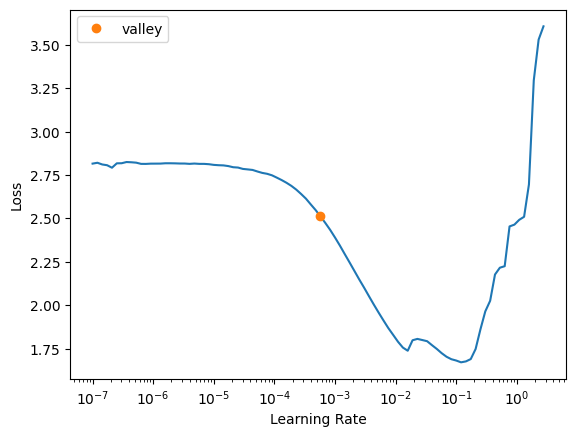

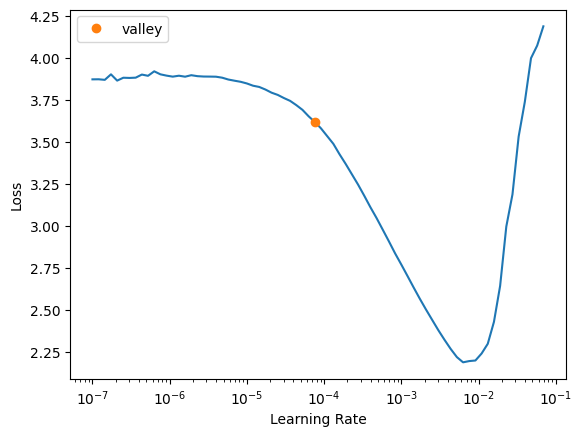

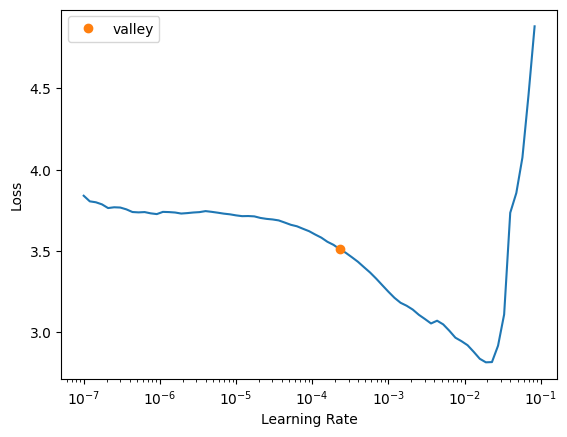

In [13]:
#Run the training and measure the time for each layer
for model, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][model] = end-start


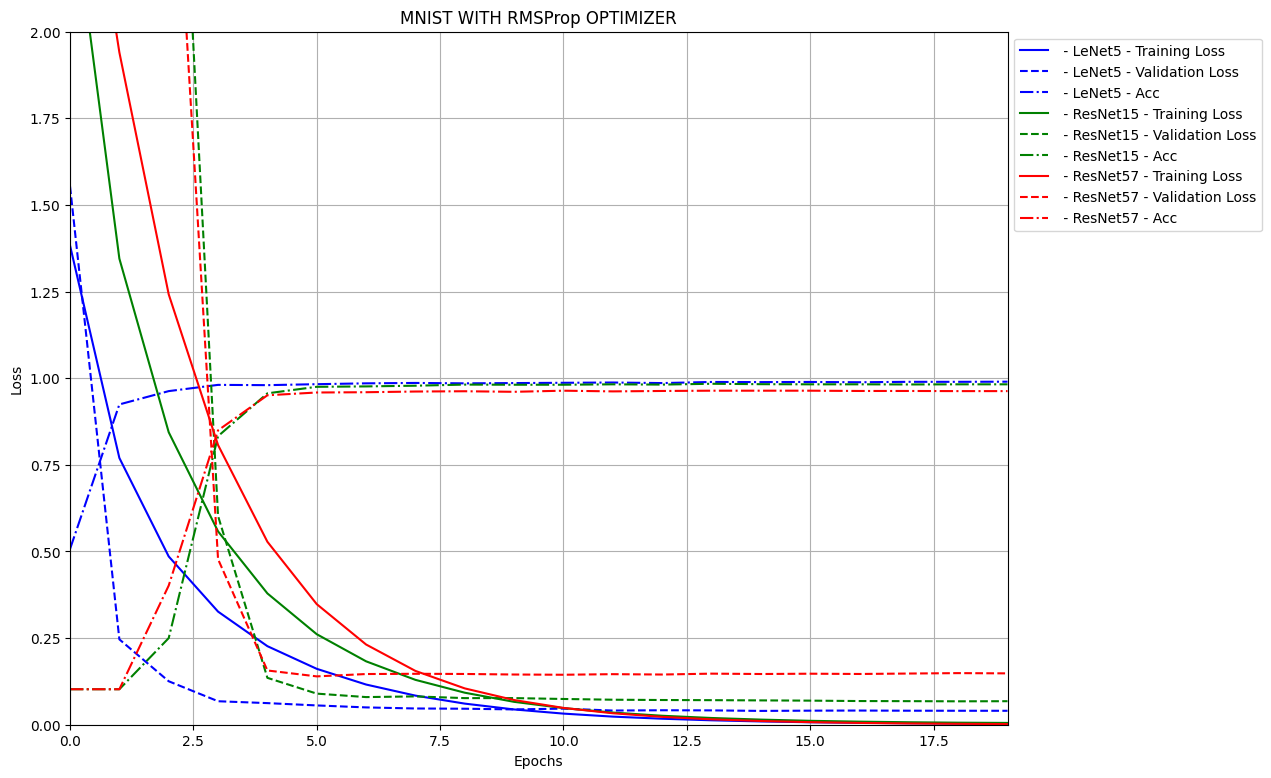

In [14]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), lim=2, title=f'{plot_dataset} WITH RMSProp OPTIMIZER', names=models, metric=metric)

### Adam

epoch,train_loss,valid_loss,accuracy,time
0,2.585463,2.349825,0.148000,00:02
1,2.063952,1.423412,0.610800,00:02
2,1.490643,0.556436,0.875600,00:02
3,1.062969,0.323342,0.920400,00:02
4,0.768903,0.226043,0.947200,00:02
5,0.565982,0.171839,0.963600,00:02
6,0.422831,0.141235,0.968800,00:02
7,0.321459,0.121656,0.972800,00:02
8,0.248511,0.106823,0.975200,00:02
9,0.194572,0.098723,0.978000,00:02


Better model found at epoch 0 with valid_loss value: 2.349825143814087.
Better model found at epoch 1 with valid_loss value: 1.4234122037887573.
Better model found at epoch 2 with valid_loss value: 0.5564356446266174.
Better model found at epoch 3 with valid_loss value: 0.32334238290786743.
Better model found at epoch 4 with valid_loss value: 0.22604285180568695.
Better model found at epoch 5 with valid_loss value: 0.17183922231197357.
Better model found at epoch 6 with valid_loss value: 0.14123527705669403.
Better model found at epoch 7 with valid_loss value: 0.12165561318397522.
Better model found at epoch 8 with valid_loss value: 0.10682304948568344.
Better model found at epoch 9 with valid_loss value: 0.09872303158044815.
Better model found at epoch 10 with valid_loss value: 0.09191175550222397.
Better model found at epoch 11 with valid_loss value: 0.08703435957431793.
Better model found at epoch 12 with valid_loss value: 0.08293616771697998.
Better model found at epoch 13 with val

epoch,train_loss,valid_loss,accuracy,time
0,3.264759,2.916741,0.103600,00:03
1,2.237349,4.964151,0.102400,00:03
2,1.462453,2.618052,0.280000,00:03
3,0.981768,0.566912,0.822400,00:03
4,0.675294,0.163300,0.950800,00:03
5,0.470806,0.116803,0.964400,00:03
6,0.331231,0.102545,0.969200,00:03
7,0.234459,0.099851,0.969200,00:03
8,0.166912,0.093736,0.973600,00:03
9,0.119029,0.091196,0.975600,00:03


Better model found at epoch 0 with valid_loss value: 2.916741371154785.
Better model found at epoch 2 with valid_loss value: 2.6180520057678223.
Better model found at epoch 3 with valid_loss value: 0.5669124126434326.
Better model found at epoch 4 with valid_loss value: 0.16330024600028992.
Better model found at epoch 5 with valid_loss value: 0.1168028712272644.
Better model found at epoch 6 with valid_loss value: 0.10254504531621933.
Better model found at epoch 7 with valid_loss value: 0.0998506098985672.
Better model found at epoch 8 with valid_loss value: 0.09373615682125092.
Better model found at epoch 9 with valid_loss value: 0.09119641035795212.
Better model found at epoch 10 with valid_loss value: 0.08859606832265854.
Better model found at epoch 11 with valid_loss value: 0.08762101083993912.
Better model found at epoch 13 with valid_loss value: 0.08630140125751495.
Better model found at epoch 14 with valid_loss value: 0.08577810972929001.
Better model found at epoch 18 with vali

epoch,train_loss,valid_loss,accuracy,time
0,3.535915,2.772827,0.097200,00:04
1,3.093247,5.807643,0.102400,00:03
2,2.592346,5.449264,0.113600,00:04
3,2.051651,2.580852,0.367200,00:03
4,1.558896,0.622161,0.808000,00:03
5,1.160725,0.386932,0.884400,00:04
6,0.850812,0.323252,0.901200,00:04
7,0.610892,0.283531,0.910000,00:04
8,0.433196,0.265378,0.918000,00:03
9,0.304086,0.265910,0.920800,00:03


Better model found at epoch 0 with valid_loss value: 2.772826671600342.
Better model found at epoch 3 with valid_loss value: 2.5808522701263428.
Better model found at epoch 4 with valid_loss value: 0.6221607327461243.
Better model found at epoch 5 with valid_loss value: 0.38693246245384216.
Better model found at epoch 6 with valid_loss value: 0.3232518136501312.
Better model found at epoch 7 with valid_loss value: 0.2835314869880676.
Better model found at epoch 8 with valid_loss value: 0.2653779089450836.


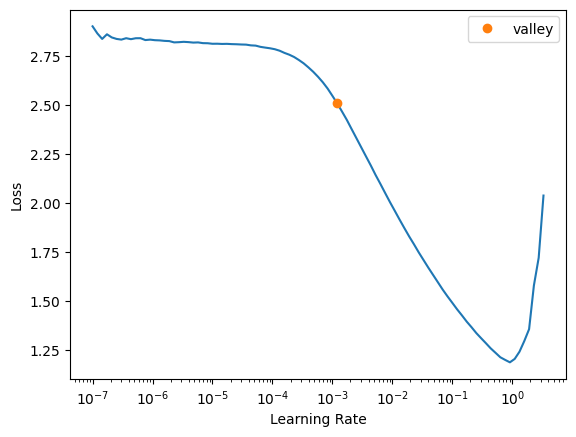

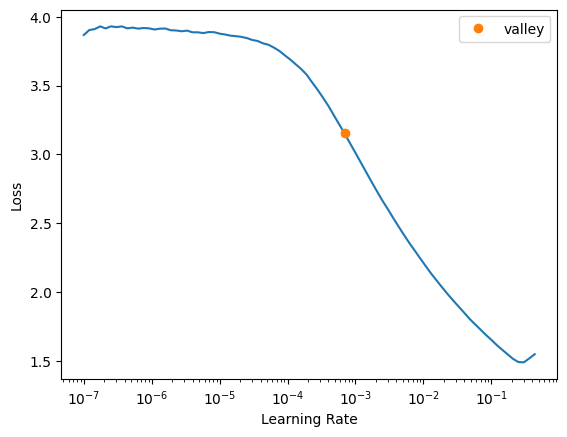

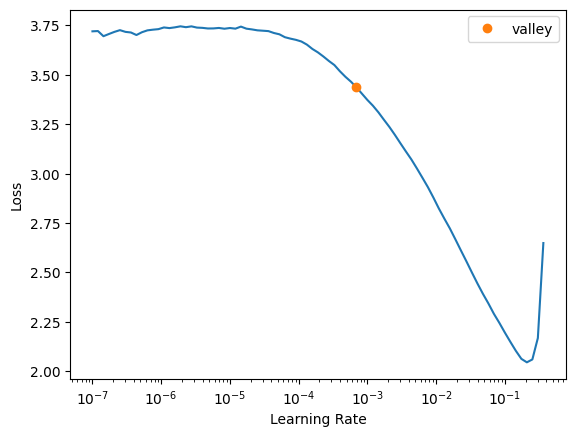

In [15]:
#Run the training and measure the time for each layer
for model, learner in learners['ADAM'].items():
  try:
    lr=learner.lr_find()
  except:
    lr=0.01
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][model] = end-start


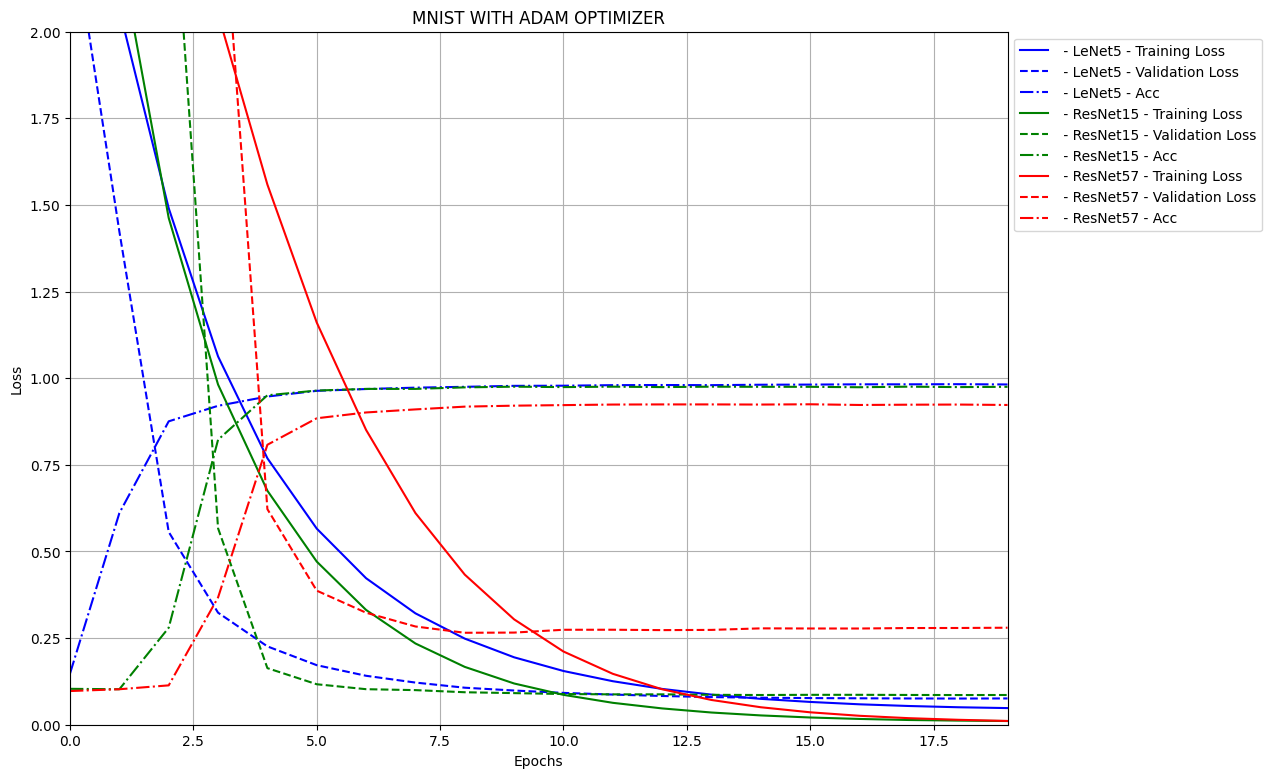

In [16]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title=f'{plot_dataset} WITH ADAM OPTIMIZER', lim=2, names=models, metric=metric)

### Save or Load models

In [17]:
#Save learner with their losses and metrics
for optim in optims:
  for model in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][model], 'recorder_values': learners[optim][model].recorder.values}, f)


In [18]:
#Load learner with their losses and metrics
for optim in optims:
  for model in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][model], learners[optim][model].recorder.values = data['learner'], data['recorder_values']

### Comparative per models

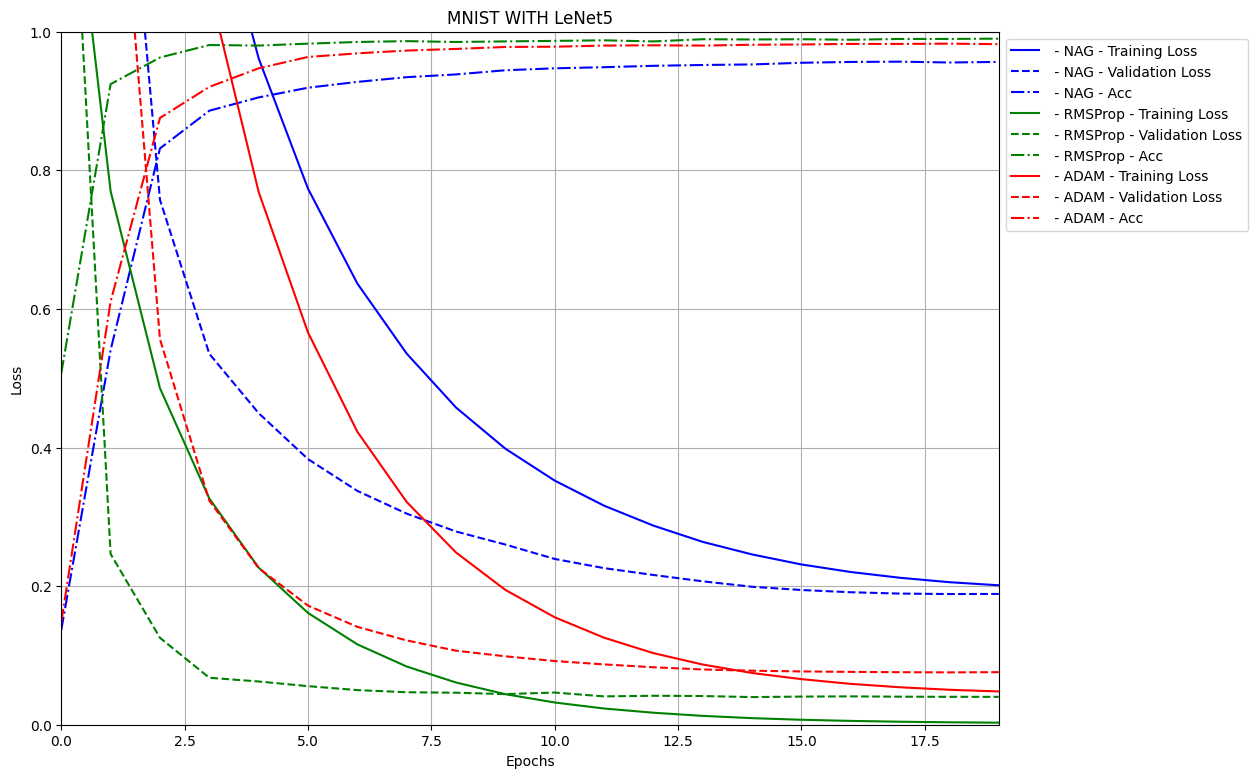

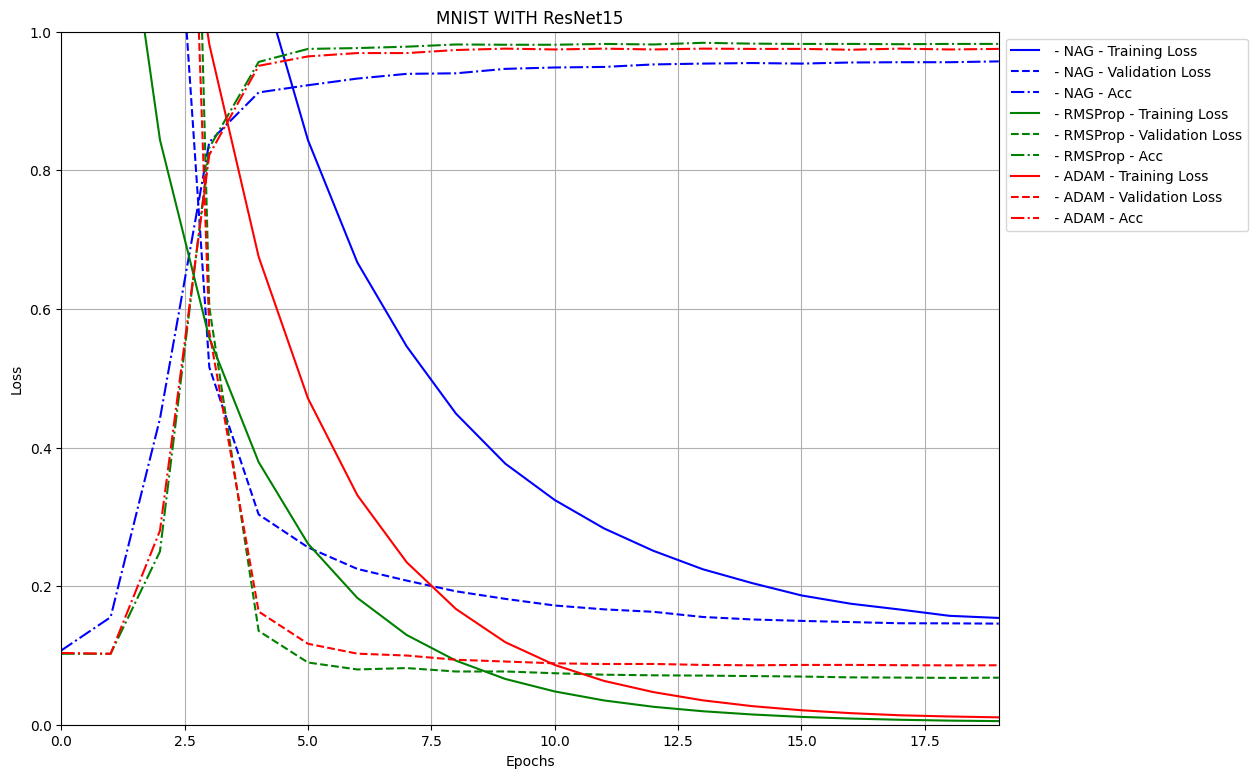

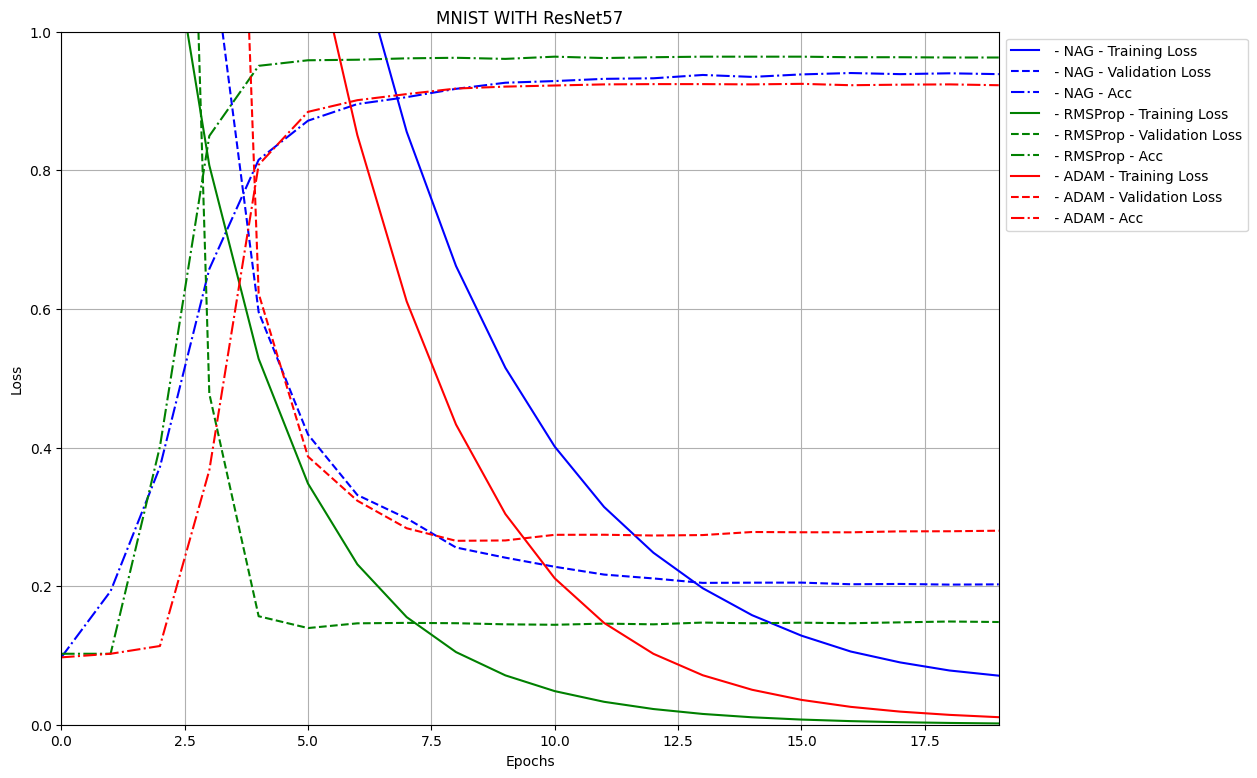

In [19]:
#Compare the three optimizers for each layer

learners_lenet =[learners['NAG']['LeNet5'], learners['RMSProp']['LeNet5'], learners['ADAM']['LeNet5']]
learners_resnet = [learners['NAG']['ResNet15'], learners['RMSProp']['ResNet15'], learners['ADAM']['ResNet15']]
learners_resnet57 = [learners['NAG']['ResNet57'], learners['RMSProp']['ResNet57'], learners['ADAM']['ResNet57']]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_lenet, title=f'{plot_dataset} WITH LeNet5', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet, title=f'{plot_dataset} WITH ResNet15', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet57, title=f'{plot_dataset} WITH ResNet57', names=names, metric=metric)

### Generalization

In [20]:
models =['LeNet5', 'ResNet15', 'ResNet57'] #Sometimes it overrides the array
#Run the model in the test set
for optim in optims:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][model].model.eval()
    learners[optim][model].eval()
    preds, targs = learners[optim][model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][model].model, test_dl, mode = 'test')
    #loss = CrossEntropyLossFlat()(preds, targs)


    print(f"Optimizer: {optim}, Model: {model}, Loss: {loss}, Accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: NAG, Model: LeNet5, Loss: 0.1918967217206955, Accuracy: 0.9549999999999998


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: NAG, Model: ResNet15, Loss: 0.14743149280548096, Accuracy: 0.9558


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: NAG, Model: ResNet57, Loss: 0.22207704186439514, Accuracy: 0.9324


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: RMSProp, Model: LeNet5, Loss: 0.05331994965672493, Accuracy: 0.9848000000000001


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: RMSProp, Model: ResNet15, Loss: 0.08493801206350327, Accuracy: 0.9782


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: RMSProp, Model: ResNet57, Loss: 0.15279744565486908, Accuracy: 0.9566000000000001


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAM, Model: LeNet5, Loss: 0.08534456044435501, Accuracy: 0.9802


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAM, Model: ResNet15, Loss: 0.10103967040777206, Accuracy: 0.9694


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAM, Model: ResNet57, Loss: 0.2888016700744629, Accuracy: 0.9132


## Metaheuristics

In [21]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}

#Initialise the population to have the same values for all the MH
for model,m in zip(models,mod):
  population[model] = []
  fitness[model] = []
  optim = NAG if model == 'ResNet57' else RMSProp
  mh_learners[model] = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(),  cbs=[SaveModelCallback()], opt_func=optim)
  mh_learners[model].to(device)
  mh_learners[model].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[model].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    population[model].append(utilsTFG.get_params_from_model(model_copy))

    fitness[model].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


### Genetic Algorithms

In [22]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [ ]:
#Runing SHADE algorithm

results['SHADE'] = {}
for model in models:
  start = time.perf_counter()
  results['SHADE'][model] = utilsTFG.SHADE_ej(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), pop_size,max_evals, len(population[model][0]), dls,  model=mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE'][model] = end-start


In [ ]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for model in models:
  fitness_valid['SHADE'][model] = []
  for ind in results['SHADE'][model][5]:
    fitness_valid['SHADE'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [ ]:
#compare train and valid and select the best generalizing model.
for model in models:
  print(f"Training error of SHADE for {model} model: {results['SHADE'][model][6]}")
  print(f"Validation error of SHADE for {model} model: {fitness_valid['SHADE'][model]}")
  dif = np.array(fitness_valid['SHADE'][model]) - np.array(results['SHADE'][model][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][model])
  best['SHADE'][model] = results['SHADE'][model][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

In [ ]:
file_path = f'/notebooks/saved_models/SHADE_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'], f)
    
file_path = f'/notebooks/saved_models/SHADE_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'], f)

### SHADE-ILS

In [ ]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for model in models:
  start = time.perf_counter()
  results['SHADE-ILS'][model] = utilsTFG.SHADE_ILS(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][model] = end-start


In [ ]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for model in models:
  fitness_valid['SHADE-ILS'][model] = []
  for ind in results['SHADE-ILS'][model][3]:
    fitness_valid['SHADE-ILS'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [ ]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS for {model} model: {results['SHADE-ILS'][model][2]}")
  print(f"Validation error of SHADE-ILS for {model} model: {fitness_valid['SHADE-ILS'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS'][model]) - np.array(results['SHADE-ILS'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][model])
  best['SHADE-ILS'][model] = results['SHADE-ILS'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

In [ ]:
file_path = f'/notebooks/saved_models/SHADE_ILS_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'], f)

### SHADE-GD

In [ ]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for model in models:
  start = time.perf_counter()
  results['SHADE-GD'][model] = utilsTFG.SHADE_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][model] = end-start


In [ ]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for model in models:
  fitness_valid['SHADE-GD'][model] = []
  for ind in results['SHADE-GD'][model][3]:
    fitness_valid['SHADE-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [ ]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-GD for {model} model: {results['SHADE-GD'][model][2]}")
  print(f"Validation error of SHADE-GD for {model} model: {fitness_valid['SHADE-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-GD'][model]) - np.array(results['SHADE-GD'][model][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][model])
  best['SHADE-GD'][model] = results['SHADE-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

In [ ]:
file_path = f'/notebooks/saved_models/SHADE-GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'], f)

### SHADE-ILS-GD

In [ ]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for model in models:
  start = time.perf_counter()
  results['SHADE-ILS-GD'][model] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]),  max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][model] = end-start


In [ ]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for model in models:
  fitness_valid['SHADE-ILS-GD'][model] = []
  for ind in results['SHADE-ILS-GD'][model][3]:
    fitness_valid['SHADE-ILS-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [ ]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS-GD for {model} model: {results['SHADE-ILS-GD'][model][2]}")
  print(f"Validation error of SHADE-ILS-GD for {model} model: {fitness_valid['SHADE-ILS-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][model]) - np.array(results['SHADE-ILS-GD'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][model])
  best['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

In [ ]:
file_path = f'/notebooks/saved_models/SHADE_ILS_GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'], f)

### Save or load

In [ ]:
#Save the mh results
file_path = f'saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
#Load the trained mh results
file_path = f'saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

### Comparison between MH

In [ ]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for model in models:
  training['SHADE'][model] = results['SHADE'][model][6]
  training['SHADE-ILS'][model] = results['SHADE-ILS'][model][2]
  training['SHADE-GD'][model] = results['SHADE-GD'][model][2]
  training['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][2]

In [ ]:
#Calculate accuracy and accuracy
acc = {}
for mh in algs:
  acc[mh] = {}
  for model in models:
    acc[mh][model] = []
    ind = 5 if mh == 'SHADE' else 3
    for ind in results[mh][model][ind]:
      utilsTFG.set_params_to_model(ind, mh_learners[model].model)
      mh_learners[model].model.eval()
      mh_learners[model].eval()
      preds, targs = mh_learners[model].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      acc[mh][model].append(accuracy(preds, targs))

In [ ]:
#Comparing the different layers version of the same MH
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], acc[alg], layers=models, names=models, title=f'TRAINING IN {plot_dataset} WITH {alg}')

In [ ]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
ac = {}
valid = {}
for model in models:
  train[model] = {}
  ac[model] = {}
  valid[model] = {}
  for alg in algs:
    train[model][alg] = training[alg][model]
    ac[model][alg] = acc[alg][model]
    valid[model][alg] = fitness_valid[alg][model]
  utilsTFG.plot_mh_mlp_training(train[model], valid[model], ac[model],  layers=names, names=names, title=f'TRAINING IN {plot_dataset} WITH {model}')

### Generalization

In [ ]:
#Run the model in the test set
for mh in algs:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][model], mh_learners[model].model)
    mh_learners[model].model.eval()
    mh_learners[model].eval()
    preds, targs = mh_learners[model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate accuracy

    accur = utilsTFG.balanced_accuracy_func(preds, targs)


    loss = utilsTFG.err_param_w_model(mh_learners[model].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Model: {model}, Loss: {loss}, Accuracy: {accur}")

## Time comparison

In [ ]:
#Compare times for each algorithm and layer

#GD
for alg, time_model in time_mh.items():
  for model, time in time_model.items():
    print(f'Time consumed by {alg} training with {model}: {time:.04f} seconds')

#MH
for optims, time_model in time_gd.items():
  for model, time in time_model.items():
    print(f'Time consumed by {optims} training with {model}: {time:.04f} seconds')

